In [ ]:
!pip install pycm livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [ ]:
import sys

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import glob
import json
import csv
from PIL import Image
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision.models import resnet18, resnet101
from torchsummary import summary
import torchvision.models as models

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
from livelossplot import PlotLosses

from windspeed import StormDataset, Surprise_StormDataset, Modified_STA_LSTM


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  # uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    print(torch.cuda.get_device_name())
    device = 'cuda'
else:
    print("No GPU available! Running on CPU")


Cuda installed! Running on GPU!
Tesla V100-SXM2-16GB


# CNN with LSTM

In [ ]:
# Create random image data (assuming each image is 3x64x64)
batch_size = 2
sequence_length = 3
image_channels = 3
image_height = 244
image_width = 244

# Create random time feature data
time_feature_dim = 2
time_features = torch.rand(batch_size, sequence_length, time_feature_dim)

# Create the model
model = Modified_STA_LSTM(time_feature_dim=time_feature_dim)

# Generate random image data
images = torch.rand(batch_size, sequence_length, image_channels, image_height, image_width)

# Perform a forward pass using the model
outputs = model(images, time_features)

# Display the model's outputs
print("Model outputs:", outputs)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model outputs: tensor([[0.0654],
        [0.0652]], grad_fn=<AddmmBackward0>)


# Train&Validation

In [ ]:
def train(model, train_loader, optimizer, criterion, device):
    """
    Train the model using the provided training data.

    Args:
        model (torch.nn.Module): The neural network model to be trained.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        optimizer (torch.optim.Optimizer): The optimizer used for gradient descent.
        criterion (torch.nn.Module): The loss function.
        device (torch.device): The device (CPU or GPU) on which the training is performed.

    Returns:
        float: Average training loss for one epoch.
    """
    model.train()  # Set the model to training mode
    total_loss = 0

    for batch in train_loader:
        images = batch['images'].to(device)
        features = batch['features'].to(device)
        labels = batch['labels'][:,-1].to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images, features)
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    return avg_loss

def validate(model, val_loader, criterion, device):
    """
    Validate the model using the provided validation data.

    Args:
        model (torch.nn.Module): The neural network model to be evaluated.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        criterion (torch.nn.Module): The loss function.
        device (torch.device): The device (CPU or GPU) on which the evaluation is performed.

    Returns:
        float: Average validation loss.
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0

    with torch.no_grad():  # Disable gradient computation
        for batch in val_loader:
            images = batch['images'].to(device)
            features = batch['features'].to(device)
            labels = batch['labels'][:,-1].to(device)  # Use labels from the last time step of the sequence

            outputs = model(images, features)
            loss = criterion(outputs.squeeze(), labels)  # Calculate loss

            total_loss += loss.item()

    avg_loss = total_loss / len(val_loader)
    return avg_loss


In [ ]:
# Function to retrieve a list of storm IDs from a specified directory
def get_storm_ids(root_dir):
    """
    Get a list of storm IDs from the specified directory.

    Args:
        root_dir (str): The root directory containing storm data folders.

    Returns:
        list: A list of storm IDs.
    """
    storm_ids = [name for name in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, name))]
    return storm_ids
root_dir =  "/content/drive/MyDrive/Selected_Storms_curated"
# Initialize the device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the list of storm IDs using the get_storm_ids function
storms = get_storm_ids(root_dir)


In [ ]:
def get_predict(storms, model, device):
    """
    Generate predictions using the provided model for a list of storms and visualize the comparison between y and y_pre.

    Args:
        storms (list): A list of storm IDs.
        model (torch.nn.Module): The trained model for making predictions.
        device (torch.device): The device (CPU or GPU) on which to perform the predictions.

    Returns:
        None: The function does not return a value but displays a comparison plot.

    Note:
        This function loads data for each storm in the list, makes predictions using the provided model, and creates
        a visualization to compare the actual values (y) with the predicted values (y_pre) for each storm.
    """
    y = torch.tensor([]).to(device)
    y_pre = torch.tensor([]).to(device)

    for storm_id in storms:
        torch.cuda.empty_cache()
        # Create a dataset for the current storm_id
        val_dataset = StormDataset(root_dir, storm_id=[storm_id], split='test')
        val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=3)

        for batch in val_loader:
            model.eval()  # Set the model to evaluation mode
            images = batch['images'].to(device)
            features = batch['features'].to(device)
            labels = batch['labels'][:,-1].to(device)  # Use labels from the last time step of the sequence

            outputs = model(images, features).to(device)
            y = torch.cat((y, labels.view(-1)), dim=0)
            y_pre = torch.cat((y_pre, outputs.view(-1)), dim=0)

        print(f"Storm ID {storm_id} input completed.")

    # Combine y and y_pre into a tensor of shape (2, n)
    combined = torch.stack([y, y_pre], dim=0)

    # Get sorted indices in ascending order based on the values in y
    sorted_indices = torch.argsort(combined[0])

    # Sort the combined tensor based on the sorted indices
    sorted_combined = combined[:, sorted_indices]
    import matplotlib.pyplot as plt
    import numpy as np

    # Sample data, replace with your own data
    y = sorted_combined[0].cpu()
    y_pre = sorted_combined[1].cpu()

    # Create x-axis coordinates
    x = np.arange(len(y))

    # Create a figure
    plt.figure(figsize=(8, 4))

    # Plot the y line chart
    plt.plot(x, y.detach().numpy(), label='y', marker='o', linestyle='-')

    # Plot the y_pre line chart
    plt.plot(x, y_pre.detach().numpy(), label='y_pre', marker='x', linestyle='--')

    # Add title and labels
    plt.title('Comparison of y and y_pre')
    plt.xlabel('Data Point')
    plt.ylabel('Values')

    # Add legend
    plt.legend()

    # Display the chart
    plt.grid(True)
    plt.show()


# Train Model

batch_size=32    sequence_length=15   

In [ ]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim
from livelossplot import PlotLosses

root_dir = '/content/drive/MyDrive/Selected_Storms_curated'

# Set some training parameters
num_epochs = 40  # Total number of epochs to train for
learning_rate = 0.0001  # Learning rate for optimizer
batch_size = 32  # Number of samples per batch

# Assuming StormDataset and Modified_STA_LSTM are defined elsewhere
# Initialize training and validation datasets
train_dataset = StormDataset(root_dir, storm_id=storms, split='train')
val_dataset = StormDataset(root_dir, storm_id=storms, split='test')

# Initialize DataLoader for training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=3)

# Initialize the model, loss function, and optimizer
model = Modified_STA_LSTM(time_feature_dim=time_feature_dim).to(device)
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression tasks
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
storms = get_storm_ids(root_dir)  # Assuming get_storm_ids function is defined elsewhere

liveloss = PlotLosses()  # Initialize PlotLosses object for live plotting of training and validation loss

# Start the training loop
for epoch in range(num_epochs):
    # Initialize a log dictionary at the beginning of each epoch
    logs = {}

    # Train and validate the model
    train_loss = train(model, train_loader, optimizer, criterion, device)  # Assuming a train function is defined
    val_loss = validate(model, val_loader, criterion, device)  # Assuming a validate function is defined

    # Update the log dictionary with training and validation loss
    logs['loss'] = train_loss
    logs['val_loss'] = val_loss

    # Print loss information for the current epoch
    print(f"Epoch {epoch+1} Train Loss: {train_loss}, Val Loss: {val_loss}")

    # Optionally save the model every 50 epochs
    if epoch % 50 == 0:
        torch.save(model.state_dict(), f'lstm_model_all_{epoch}.pth')

    # Update and send the live loss plot after processing all storms
    liveloss.update(logs)
    liveloss.send()


In [ ]:
torch.save(model.state_dict(), 'lstm_model_all.pth')

# Model Result

In [ ]:
# Initialize empty tensors for ground truth (y) and predictions (y_pre)
y = torch.tensor([]).to(device)
y_pre = torch.tensor([]).to(device)

# Set the model to evaluation mode
model.eval()

# Disable gradient computation (no gradient calculation needed during evaluation)
with torch.no_grad():
    # Iterate through the validation data loader
    for batch in val_loader:
        # Move input data to the device (GPU)
        images = batch['images'].to(device)
        features = batch['features'].to(device)

        # Extract the labels from the last time step of the sequences
        labels = batch['labels'][:,-1].to(device)

        # Forward pass through the model to get predictions
        outputs = model(images, features)

        # Concatenate the ground truth and predictions along a specified dimension
        y = torch.cat((y, labels.view(-1)), dim=0)
        y_pre = torch.cat((y_pre, outputs.view(-1)), dim=0)


In [ ]:
# Combine y and y_pre into a tensor of shape (2, n)
combined = torch.stack([y, y_pre], dim=0)

# Get sorted indices based on the values in y in ascending order
sorted_indices = torch.argsort(combined[0])

# Sort the combined tensor using the sorted indices
sorted_combined = combined[:, sorted_indices]

# Print the result
print(sorted_combined)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data, replace with your own data
y = sorted_combined[0].cpu()
y_pre = sorted_combined[1].cpu()

# Create x-axis coordinates
x = np.arange(len(y))

# Create a figure
plt.figure(figsize=(8, 4))

# Plot the line chart for y
plt.plot(x, y, label='y', marker='o', linestyle='-')

# Plot the line chart for y_pre
plt.plot(x, y_pre, label='y_pre', marker='x', linestyle='--')

# Add title and labels
plt.title('Comparison of y and y_pre')
plt.xlabel('Data Point')
plt.ylabel('Values')

# Add legend
plt.legend()

# Show the chart
plt.grid(True)
plt.show()


In [ ]:
# Sample data, replace with your own data
y = sorted_combined[0].cpu()
y_pre = sorted_combined[1].cpu()

# Calculate Mean Squared Error (MSE)
mse = torch.mean((y - y_pre) ** 2).item()  # Convert the result to a scalar using .item()

# Calculate the mean of y
y_mean = torch.mean(y).item()  # Convert the result to a scalar using .item()

# Calculate relative Mean Squared Error (rMSE)
rmse = torch.sqrt(torch.tensor(mse)) / y_mean

print(f'RMSE: {rmse.item()}')


# Predict on Surprise_Storm


In [ ]:
# Set the root directory for storm data
root_dir = '/content/drive/MyDrive/Surprise_Storm'

# Initialize the device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the list of storm IDs using the get_storm_ids function
storms = get_storm_ids(root_dir)

In [ ]:
# 创建一个与原始模型相同结构的模型实例
loaded_model = Modified_STA_LSTM(time_feature_dim=time_feature_dim).to(device)

# 加载已保存的模型状态字典
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/lstm_model_all.pth'))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
storms_dataset = StormDataset(root_dir, storm_id=storms)
storms_loader = DataLoader(storms_dataset, batch_size=1, shuffle=True, num_workers=3)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
dataset = [storms_dataset[i] for i in range(len(storms_dataset)-12)]
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=3)

In [ ]:
# Initialize empty tensors for ground truth (y) and predictions (y_pre)
y = torch.tensor([]).to(device)
y_pre = torch.tensor([]).to(device)

# Set the model to evaluation mode
loaded_model.eval()

# Disable gradient computation (no gradient calculation needed during evaluation)
with torch.no_grad():
    # Iterate through the validation data loader
    for batch in loader:
        # Move input data to the device (GPU)
        images = batch['images'].to(device)
        features = batch['features'].to(device)

        # Extract the labels from the last time step of the sequences
        labels = batch['labels'][:,-1].to(device)

        # Forward pass through the model to get predictions
        outputs = loaded_model(images, features)

        # Concatenate the ground truth and predictions along a specified dimension
        y = torch.cat((y, labels.view(-1)), dim=0)
        y_pre = torch.cat((y_pre, outputs.view(-1)), dim=0)


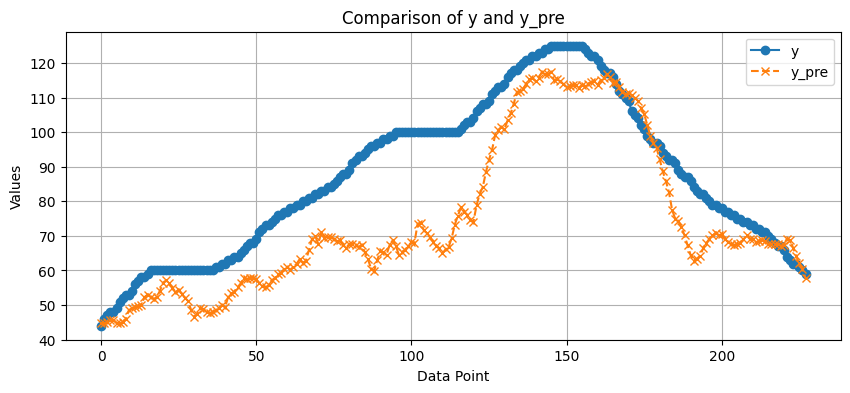

In [ ]:
y = y.cpu()
y_pre = y_pre.cpu()
# Create x-axis coordinates
x = np.arange(len(y))

# Create a figure
plt.figure(figsize=(10, 4))

# Plot the line chart for y
plt.plot(x, y, label='y', marker='o', linestyle='-')

# Plot the line chart for y_pre
plt.plot(x, y_pre, label='y_pre', marker='x', linestyle='--')

# Add title and labels
plt.title('Comparison of y and y_pre')
plt.xlabel('Data Point')
plt.ylabel('Values')

# Add legend
plt.legend()

# Show the chart
plt.grid(True)
plt.show()


# Fine-tuning

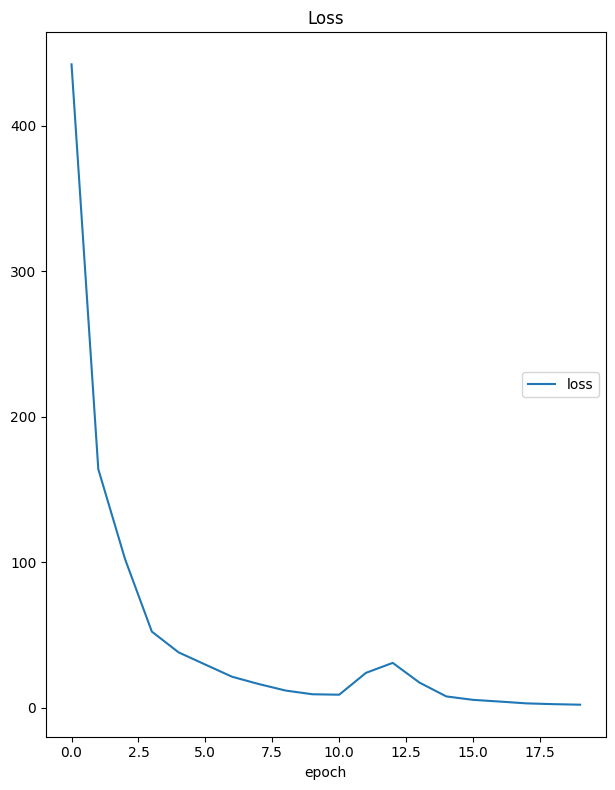

Loss
	loss             	 (min:    2.213, max:  442.158, cur:    2.213)


In [ ]:
# Set some training parameters
num_epochs = 20  # Number of epochs to train for
learning_rate = 0.0001  # Learning rate for the optimizer
batch_size = 20  # Batch size for training

# Initialize the model, loss function, and optimizer
model = loaded_model  # Assuming loaded_model is a pre-initialized model instance
criterion = nn.MSELoss()  # Mean Squared Error Loss function for regression tasks
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer with the defined learning rate

liveloss = PlotLosses()  # Initialize a PlotLosses object for live plotting of the training loss

# Start the training loop
for epoch in range(num_epochs):
    # Initialize a log dictionary at the beginning of each epoch
    logs = {}

    # Train and validate the model
    train_loss = train(model, loader, optimizer, criterion, device)  # Assuming a train function is defined elsewhere

    # Update the log dictionary with the training loss
    logs['loss'] = train_loss

    # Print the loss information
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}")

    # Update and send the live loss plot after going through all storms
    liveloss.update(logs)
    liveloss.send()


In [ ]:
# Initialize empty tensors for ground truth (y) and predictions (y_pre)
y = torch.tensor([]).to(device)
y_pre = torch.tensor([]).to(device)

# Set the model to evaluation mode
loaded_model.eval()

# Disable gradient computation (no gradient calculation needed during evaluation)
with torch.no_grad():
    # Iterate through the validation data loader
    for batch in loader:
        # Move input data to the device (GPU)
        images = batch['images'].to(device)
        features = batch['features'].to(device)

        # Extract the labels from the last time step of the sequences
        labels = batch['labels'][:,-1].to(device)

        # Forward pass through the model to get predictions
        outputs = loaded_model(images, features)

        # Concatenate the ground truth and predictions along a specified dimension
        y = torch.cat((y, labels.view(-1)), dim=0)
        y_pre = torch.cat((y_pre, outputs.view(-1)), dim=0)


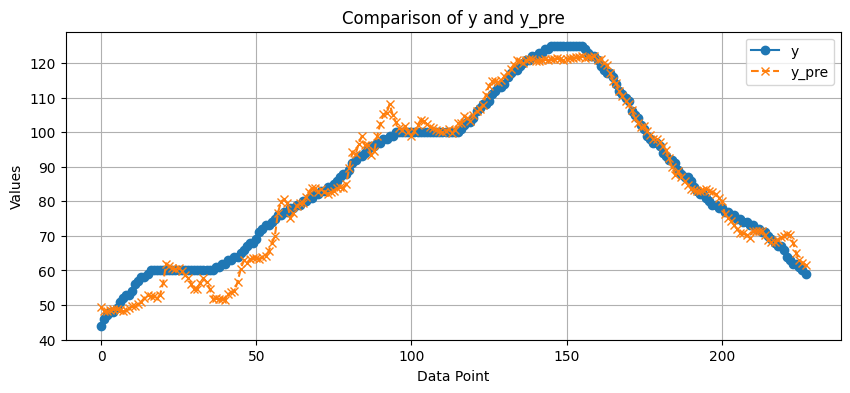

In [ ]:
y = y.cpu()
y_pre = y_pre.cpu()
# Create x-axis coordinates
x = np.arange(len(y))

# Create a figure
plt.figure(figsize=(10, 4))

# Plot the line chart for y
plt.plot(x, y, label='y', marker='o', linestyle='-')

# Plot the line chart for y_pre
plt.plot(x, y_pre, label='y_pre', marker='x', linestyle='--')

# Add title and labels
plt.title('Comparison of y and y_pre')
plt.xlabel('Data Point')
plt.ylabel('Values')

# Add legend
plt.legend()

# Show the chart
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
def evaluate_metrix(y, y_pre):
  mse = mean_squared_error(y,y_pre)  # Convert the result to a scalar using .item()
  rmse = np.sqrt(mse)
  r2 = r2_score(y,y_pre)
  print(f'RMSE: {rmse}')
  print(f'r2: {r2}')

In [ ]:
evaluate_metrix(y, y_pre)

RMSE: 4.235118389129639
r2: 0.9638657394259741


In [ ]:
# torch.save(loaded_model.state_dict(), 'lstm_model_surprise.pth')

# Predict


In [ ]:
# Create an instance of the model with the same structure as the original one
loaded_model = Modified_STA_LSTM(time_feature_dim=time_feature_dim).to(device)

# Load the saved model state dictionary
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/lstm_model_surprise.pth'))

<All keys matched successfully>

In [ ]:
storms_dataset = Surprise_StormDataset(root_dir)
storms_loader = DataLoader(storms_dataset, batch_size=1, shuffle=False, num_workers=3)

In [ ]:
len(storms_dataset)

241

In [ ]:
# Initialize empty tensors for ground truth (y) and predictions (y_pre)
y_pre = torch.tensor([]).to(device)

# Set the model to evaluation mode
loaded_model.eval()

# Disable gradient computation (no gradient calculation needed during evaluation)
with torch.no_grad():
    # Iterate through the validation data loader
    for batch in storms_loader:
        # Move input data to the device (GPU)
        images = batch['images'].to(device)
        features = batch['features'].to(device)

        # Forward pass through the model to get predictions
        outputs = loaded_model(images, features)

        # Concatenate the ground truth and predictions along a specified dimension
        y_pre = torch.cat((y_pre, outputs.view(-1)), dim=0)

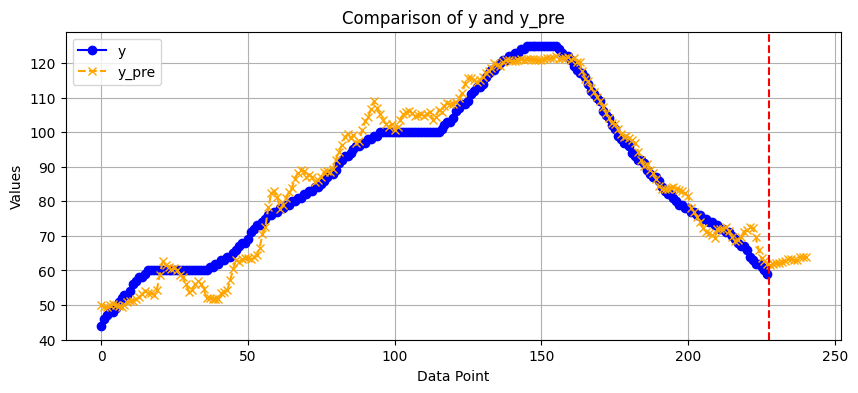

In [ ]:
# Convert y_pre from a PyTorch tensor to a numpy array for plotting
y_pre = y_pre.cpu()

# Create x-axis coordinates based on the length of y
x = np.arange(len(y))

# Create a figure with a specified size
plt.figure(figsize=(10, 4))

# Plot the line chart for y using circles ('o') for data points and a solid line ('-') for connections
plt.plot(x, y, label='y', marker='o', linestyle='-', color='blue')

# For y_pre, create x-axis coordinates based on its length
x_pre = np.arange(len(y_pre))

# Plot the line chart for y_pre using 'x' markers and a dashed line ('--')
plt.plot(x_pre, y_pre, label='y_pre', marker='x', linestyle='--', color='orange')

# Add a title to the plot
plt.title('Comparison of y and y_pre')

# Label the x-axis as 'Data Point'
plt.xlabel('Data Point')

# Label the y-axis as 'Values'
plt.ylabel('Values')

# Add a legend to the plot to identify the lines
plt.legend()

# Determine the shorter length between y and y_pre to find where to draw the boundary line
min_length = min(len(y), len(y_pre))

# Draw a vertical red dashed line ('--') at the boundary between y and y_pre lengths
plt.axvline(x=min_length-0.5, color='r', linestyle='--', label='Boundary')

# Enable grid for better readability of the plot
plt.grid(True)

# Display the plot
plt.show()


In [ ]:
y_pre[-13:]

tensor([61.5478, 61.8260, 62.0796, 62.1417, 62.3648, 62.7586, 63.3193, 63.3976,
        62.9728, 62.9936, 63.9592, 63.8939, 64.0150])